## Objective 

The objective of this notebook is to solve the third programming assignment of Andrew Ng's Machine Learning course on Coursera using Python. I have also taken a snapshot of the important concepts relating to the topics taught in this week that I'll be pasting in my notebook.

In [1]:
from IPython.display import Image

In [2]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from scipy.io import loadmat
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#To read the matlab matrix in Python
data = loadmat('ex4data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
X=data['X']
y=data['y']
print('The dimension of the matrices X and Y are',X.shape,'and',y.shape,'respectively.')
print('The number of unique values in y are:',np.unique(y))

The dimension of the matrices X and Y are (5000, 400) and (5000, 1) respectively.
The number of unique values in y are: [ 1  2  3  4  5  6  7  8  9 10]


Every row in the matrix is an image. The dimension of every image is 20x20 and these 400 pixels have been unrolled into one vector, thus the dimension of the matrix is 5000x400. y has 5000 labels - the class to which every picture belongs. Now, pictures with 0 have the class label 10. This has been done for the purpose of this course as indexing in MATLAB starts from 1.

The label is 10


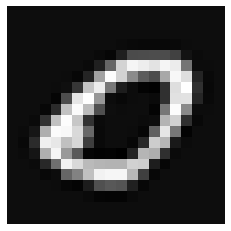

In [5]:
#To show the X and y for one particular image
plt.imshow(X[0].reshape(20,20),cmap='gray')
plt.xticks([])
plt.yticks([])
print('The label is',y[0][0])

In [6]:
#To load the weights from the MATLAB file onto Python
weights = loadmat('ex4weights.mat')
Theta1=weights['Theta1']
Theta2=weights['Theta2']
print('The dimensions of Theta1 and Theta2 are',Theta1.shape,'and',Theta2.shape,'respectively.')

The dimensions of Theta1 and Theta2 are (25, 401) and (10, 26) respectively.


## Cost Function 

![title](NN Cost Function.png)

The first part is like a double for loop, where we are iterating through each of our 'm' training examples and for every training example we are outputting a hypothesis for each of the 'K' classes. 

The second part is a triple sum where we are essentially trying to regularize the thetas in our entire network. Corresponding to 'L' layers of the neural network, we will be having (L-1) thetas, and corresponding to each theta, we will iterate through each of the columns and within each column we will be squaring all the thetas.

In [7]:
def SIGMOID(z):
    #Using np.exp is beneficial as it does the operation in a vectorised manner
    return(1/(1+np.exp(-z)))

In Neural Networks, the gradient of the thetas is a matrix and not a vector like in the previous exercises. However our optimization algorithms take in thetas as vectors and not matrices. Thus we pass thetas as a vector and later reshape it inside the cost function

In [8]:
Theta=np.array(Theta1.flatten().tolist()+Theta2.flatten().tolist())
#Unregularised cost function
def NNCOST(Theta,X,y,K,hidden_layer_size):
    m=X.shape[0]
    n=X.shape[1]
    
    Theta1=Theta[:hidden_layer_size*(n+1)].reshape(hidden_layer_size,n+1)
    Theta2=Theta[hidden_layer_size*(n+1):].reshape(K,hidden_layer_size+1)
    
    a1=np.hstack((np.ones((m,1)),X))
    z2=np.dot(a1,Theta1.T)
    a2=SIGMOID(z2)
    a2=np.hstack((np.ones((m,1)),a2))
    z3=np.dot(a2,Theta2.T)
    a3=SIGMOID(z3)
    yk=np.zeros((m,K))
    for i in range(m):
        yk[i,y[i]-1]=1
    cost=(-1/m)*sum(sum(np.multiply(yk,np.log(a3))+np.multiply(1-yk,np.log(1-a3))))
    return(cost)

Explanation:

- a1(X) is a matrix of dimension (m x n+1)
- z2 is a dot product of a1 and transpose of Theta1
- a2 is the activation in the second layer and is = g(z2)
- We then add a column of 1s that represents the bias node in the second layer
- z3 is a dot product of a2 and transpose of Theta2
- a3 is the final hypothesis and = g(z3)
- yk is a (m x K) dimensional matrix that has 1s at the positions defined by the class that the ith value in y belongs to
- We then do an element wise multiplication of yk with the (m x K) dimensional hypothesis and then sum over the costs of misclassification. This resembles our cost function for logistic regression

In [9]:
NNCOST(Theta,X,y,10,25)

0.28762916516131881

In [10]:
#Regularised cost function
def NNCOSTREG(Theta,X,y,K,hidden_layer_size,lam):
    m=X.shape[0]
    n=X.shape[1]
    
    Theta1=Theta[:hidden_layer_size*(n+1)].reshape(hidden_layer_size,n+1)
    Theta2=Theta[hidden_layer_size*(n+1):].reshape(K,hidden_layer_size+1)
    
    a1=np.hstack((np.ones((m,1)),X))
    z2=np.dot(a1,Theta1.T)
    a2=SIGMOID(z2)
    a2=np.hstack((np.ones((m,1)),a2))
    z3=np.dot(a2,Theta2.T)
    a3=SIGMOID(z3)
    yk=np.zeros((m,K))
    for i in range(m):
        yk[i,y[i]-1]=1
    cost=(-1/m)*sum(sum(np.multiply(yk,np.log(a3))+np.multiply(1-yk,np.log(1-a3))))
    reg=(lam/(2*m))*(sum(sum(np.square(Theta1[:,1:])))+sum(sum(np.square(Theta2[:,1:]))))
    return(cost+reg)

Explanation:

- a1(X) is a matrix of dimension (m x n+1)
- z2 is a dot product of a1 and transpose of Theta1
- a2 is the activation in the second layer and is = g(z2)
- We then add a column of 1s that represents the bias node in the second layer
- z3 is a dot product of a2 and transpose of Theta2
- a3 is the final hypothesis and = g(z3)
- yk is a (m x K) dimensional matrix that has 1s at the positions defined by the class that the ith value in y belongs to
- We then do an element wise multiplication of yk with the (m x K) dimensional hypothesis and then sum over the costs of misclassification. This resembles our cost function for logistic regression
- However we now have to regularize our thetas, by squaring over all terms except the first column and multiplying with (lambda/2m) 

In [11]:
NNCOSTREG(Theta,X,y,10,25,1)

0.38376985909092354

## Backpropogation 

![title](NN Backpropogation.png)

In [12]:
def SIGMOIDGRAD(z):
    g=(1/(1+np.exp(-z)))
    return(np.multiply((g),(1-g)))

Explanation:

- This is the gradient of the SIGMOID function

![title](NN Sigmoid Grad 1.png)

![title](NN Rand Init.png)

In [13]:
def RANDINIT(L_in,L_out):
    eps_init=np.sqrt(6)/np.sqrt(L_in+L_out)
    return(np.random.rand(L_in,L_out)*2*eps_init - eps_init)

In [14]:
def BACKPROP(Theta,X,y,K,hidden_layer_size):
    
    m=X.shape[0]
    n=X.shape[1]
    
    Theta1=Theta[:hidden_layer_size*(n+1)].reshape(hidden_layer_size,n+1)
    Theta2=Theta[hidden_layer_size*(n+1):].reshape(K,hidden_layer_size+1)
    
    yk=np.zeros((m,K))
    for i in range(m):
        yk[i,y[i]-1]=1
    
    DELTA_1=0
    DELTA_2=0
    
    for i in range(m):
        a1=np.hstack((1,X[i,:])).reshape(1,n+1) #Stacking to a one dimensional array
        z2=np.dot(a1,Theta1.T) 
        a2=SIGMOID(z2)
        a2=np.hstack((np.ones((1,1)),a2)).reshape(1,hidden_layer_size+1) #Stacking to a two dimensional array
        z3=np.dot(a2,Theta2.T)
        a3=SIGMOID(z3).reshape(1,K) 
        
        yi=yk[i,:].reshape(1,K) #1x(no. of classes)
        
        delta_3=(a3-yi).reshape(1,K) #1x(no. of classes)
        delta_2=np.multiply(np.dot(delta_3,Theta2[:,1:]),
                            SIGMOIDGRAD(z2)).reshape(1,hidden_layer_size) #1x(no. of nodes in the middle layer)
        
        DELTA_1=DELTA_1+np.dot(delta_2.T,a1) #(no. of nodes in the middle layer)x(n+1)
        DELTA_2=DELTA_2+np.dot(delta_3.T,a2) #(no. of classes)x(no. of nodes in the middle layer + 1)
    
    Theta1_grad=(1/m)*DELTA_1 #same dimensions as Theta1
    Theta2_grad=(1/m)*DELTA_2 #same dimensions as Theta2
    
    Theta_grad=np.array(Theta1_grad.flatten().tolist()+Theta2_grad.flatten().tolist())
    
    return(Theta_grad)

Explanation: 

- Backpropogation as an algorithm, has a similar objective to that of gradient descent where we are essentially trying to minimize the cost function    
- We set DELTA_1 and DELTA_2 to 0 as we treat it as an accumalator to add up our values as we go along and eventually compute the partial derivative of the J with respect to the Theta matrices 
- Inside the for loop, we iterate through every row of the design matrix X and compute the activations in the second and the third layer (a2 and a3)
- When we calculate the deltas, we are essentially trying to find the error of node j in layer L. delta_3 is the error term for the the 10 nodes in the last layer
- We then again calculate the deltas in the second layer (delta_2), which is found by taking a dot product of delta_3 and Theta2 (excluding the first column as the first column is for the bias unit). We term this method as backpropogation as were are trying to take the errors of the (n+1)th layer to the nth layer and then try to change the set of thetas that map the activation units from the nth to the (n+1)th layer. We also make an element wise mutiplication with the the sigmoid gradient of z2 (z2 as we are ignoring the bias unit in a2)
- The DELTA_1 and DELTA_2 values get updated after every iteration (that is from the 1st to mth value in X)
- From the perspective of the neural network, we only really complete one iteration and what we have essentially calculated is the partial derivative of J with respect to the Theta matrices

In [15]:
#To randomly initialize the Thetas so as to break symmetry
initial_theta1=RANDINIT(25,401)
initial_theta2=RANDINIT(10,26)
initial_theta=np.array(initial_theta1.flatten().tolist()+initial_theta2.flatten().tolist()) 

In [16]:
import scipy.optimize as opt

In [17]:
opt_result_50=opt.minimize(fun=NNCOST, x0=initial_theta, jac=BACKPROP, method='TNC',
                args=(X,y,10,25), options={'maxiter': 50})
opt_result_50

     fun: 0.67400565545932756
     jac: array([ -3.44450424e-04,   0.00000000e+00,   0.00000000e+00, ...,
        -2.36636020e-05,  -7.81020380e-03,  -8.02578183e-03])
 message: 'Max. number of function evaluations reached'
    nfev: 50
     nit: 8
  status: 3
 success: False
       x: array([ 0.51913547, -0.0248553 ,  0.03239696, ..., -1.25231209,
       -0.81829371,  1.14697397])

In [19]:
#Increasing the number of iterations
opt_result_250=opt.minimize(fun=NNCOST, x0=initial_theta, jac=BACKPROP, method='TNC',
                args=(X,y,10,25), options={'maxiter': 250})
opt_result_250

     fun: 0.036467775635895879
     jac: array([  5.43305092e-06,   0.00000000e+00,   0.00000000e+00, ...,
         5.81957235e-05,   7.33445911e-05,   1.66545889e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 19
  status: 3
 success: False
       x: array([ 1.29262489, -0.0248553 ,  0.03239696, ..., -1.41841189,
       -1.44696555,  1.56271153])

Alright, so the function value has decreased a lot with an increase in the number of iterations, which means it is possible that our neural network has overfit to the training data.

In [20]:
#To compute the accuracy 
final_theta=opt_result_250['x']
def predict_nn(Theta,X,K,hidden_layer_size):
    m=X.shape[0]
    n=X.shape[1]
    
    Theta1=Theta[:hidden_layer_size*(n+1)].reshape(hidden_layer_size,n+1)
    Theta2=Theta[hidden_layer_size*(n+1):].reshape(K,hidden_layer_size+1)
    
    a1=np.hstack((np.ones((m,1)),X))
    z2=np.dot(a1,Theta1.T)
    a2=SIGMOID(z2)
    a2=np.hstack((np.ones((m,1)),a2))
    z3=np.dot(a2,Theta2.T)
    a3=SIGMOID(z3)
    predictions=np.argmax(a3,axis=1)+1
    return(predictions)

print('The accuracy of the classifier is',np.mean(predict_nn(final_theta,X,10,25)==y.flatten())*100,'%')

The accuracy of the classifier is 99.9 %


Explanation: 

- a1(X) is a matrix of dimension (m x n+1)
- z2 is a dot product of a1 and transpose of Theta1
- a2 is the activation in the second layer and is = g(z2)
- We then add a column of 1s that represents the bias node in the second layer
- z3 is a dot product of a2 and transpose of Theta2
- a3 is the final hypothesis and = g(z3)
- yk is a (m x K) dimensional matrix that has 1s at the positions defined by the class that the ith value in y belongs to
- Like in the multiclass classification problem we choose the hypothesis that has the maximum value for a given class

Now although this accuracy is stellar, we don't know if the model will generalize well to unseen tests cases. Thus we need to regularize the thetas

In [21]:
def BACKPROPREG(Theta,X,y,K,hidden_layer_size,lam):
    
    m=X.shape[0]
    n=X.shape[1]
    
    Theta1=Theta[:hidden_layer_size*(n+1)].reshape(hidden_layer_size,n+1)
    Theta2=Theta[hidden_layer_size*(n+1):].reshape(K,hidden_layer_size+1)
    
    yk=np.zeros((m,K))
    for i in range(m):
        yk[i,y[i]-1]=1
    
    DELTA_1=0
    DELTA_2=0
    
    for i in range(m):
        a1=np.hstack((1,X[i,:])).reshape(1,n+1) #Stacking to a one dimensional array
        z2=np.dot(a1,Theta1.T) 
        a2=SIGMOID(z2)
        a2=np.hstack((np.ones((1,1)),a2)).reshape(1,hidden_layer_size+1) #Stacking to a two dimensional array
        z3=np.dot(a2,Theta2.T)
        a3=SIGMOID(z3).reshape(1,K) 
        
        yi=yk[i,:].reshape(1,K) #1x(no. of classes)
        
        delta_3=(a3-yi).reshape(1,K) #1x(no. of classes)
        delta_2=np.multiply(np.dot(delta_3,Theta2[:,1:]),
                            SIGMOIDGRAD(z2)).reshape(1,hidden_layer_size) #1x(no. of nodes in the middle layer)
        
        DELTA_1=DELTA_1+np.dot(delta_2.T,a1) #(no. of nodes in the middle layer)x(n+1)
        DELTA_2=DELTA_2+np.dot(delta_3.T,a2) #(no. of classes)x(no. of nodes in the middle layer + 1)
    
    Theta1_grad=(1/m)*DELTA_1 + np.hstack((np.zeros((hidden_layer_size,1)),(lam/m)*DELTA_1[:,1:]))
    Theta2_grad=(1/m)*DELTA_2 + np.hstack((np.zeros((K,1)),(lam/m)*DELTA_2[:,1:]))
    
    Theta_grad=np.array(Theta1_grad.flatten().tolist()+Theta2_grad.flatten().tolist())
    
    return(Theta_grad)

Explanation: 

- Backpropogation as an algorithm, has a similar objective to that of gradient descent where we are essentially trying to minimize the cost function    
- We set DELTA_1 and DELTA_2 to 0 as we treat it as an accumalator to add up our values as we go along and eventually compute the partial derivative of the J with respect to the Theta matrices 
- Inside the for loop, we iterate through every row of the design matrix X and compute the activations in the second and the third layer (a2 and a3)
- When we calculate the deltas, we are essentially trying to find the error of node j in layer L. delta_3 is the error term for the the 10 nodes in the last layer
- We then again calculate the deltas in the second layer (delta_2), which is found by taking a dot product of delta_3 and Theta2 (excluding the first column as the first column is for the bias unit). We term this method as backpropogation as were are trying to take the errors of the (n+1)th layer to the nth layer and then try to change the set of thetas that map the activation units from the nth to the (n+1)th layer. We also make an element wise mutiplication with the the sigmoid gradient of z2 (z2 as we are ignoring the bias unit in a2)
- The DELTA_1 and DELTA_2 values get updated after every iteration (that is from the 1st to mth value in X)
- Then we regularize the columns in the Theta matrices excluding the first column
- From the perspective of the neural network, we only really complete one iteration and what we have essentially calculated is the partial derivative of J with respect to the Theta matrices

In [22]:
opt_result_50_REG=opt.minimize(fun=NNCOSTREG, x0=initial_theta, jac=BACKPROPREG, method='TNC',
                args=(X,y,10,25,1), options={'maxiter': 50})
opt_result_50_REG

     fun: 0.92933629469925805
     jac: array([ 0.00024908,  0.        ,  0.        , ...,  0.00149312,
       -0.00184368, -0.00205029])
 message: 'Max. number of function evaluations reached'
    nfev: 50
     nit: 6
  status: 3
 success: False
       x: array([ 0.10195274, -0.0248553 ,  0.03239696, ..., -0.93383299,
       -0.78851334,  1.22254729])

In [23]:
#Increasing the number of iterations
opt_result_250_REG=opt.minimize(fun=NNCOSTREG, x0=initial_theta, jac=BACKPROPREG, method='TNC',
                args=(X,y,10,25,1), options={'maxiter': 250})
opt_result_250_REG

     fun: 0.58789165644948604
     jac: array([-0.00092871,  0.        ,  0.        , ...,  0.00018626,
       -0.0017618 , -0.00316913])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 240
     nit: 15
  status: 1
 success: True
       x: array([ 0.50625545, -0.0248553 ,  0.03239696, ..., -1.38966719,
       -1.16734853,  1.95659102])

In [24]:
final_theta_REG=opt_result_250_REG['x']
print('The accuracy of the classifier is',np.mean(predict_nn(final_theta_REG,X,10,25)==y.flatten())*100,'%')

The accuracy of the classifier is 97.48 %


Which is pretty impressive considering we have incorporated regularization in our model.

### Backpropogation Intuition 

![title](NN Backpropogation Intuition.png)